# 영화 흥행 요인 분석

## 목적
흥행작과 비흥행작의 줄거리를 분석하여 각각의 특징적인 키워드와 유형을 파악

## 파이프라인
1. 데이터 로드 및 전처리
2. 흥행/비흥행 라벨링
3. TF-IDF 키워드 비교 분석
4. BERTopic 토픽 모델링
5. 워드클라우드 시각화

In [2]:
## 라이브러리 설치
!pip install bertopic sentence-transformers umap-learn hdbscan pandas numpy wordcloud matplotlib

---

# 1. 라이브러리 임포트 및 데이터 로드

In [46]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from umap import UMAP
from hdbscan import HDBSCAN
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Pandas 출력 옵션 설정
pd.set_option('display.max_columns', None)      # 모든 컬럼 표시
pd.set_option('display.max_colwidth', None)     # 컬럼 내용 전체 표시 (잘림 방지)
pd.set_option('display.width', None)            # 출력 너비 제한 해제
pd.set_option('display.max_rows', None)         # 모든 행 표시

# 데이터 로드
df = pd.read_csv("data/movies_clean.csv")

# 결측치 제거: overview(줄거리)나 vote_average(평점)가 없으면 분석 불가
df = df.dropna(subset=['overview', 'vote_average'])

print(f"전체 영화 수: {len(df)}")
df[['title', 'vote_average', 'genres', 'overview']].head(3)

전체 영화 수: 9465


,title,vote_average,genres,overview
0,Creed III,7.100,"[""Drama"", ""Action""]","After dominating the boxing world, Adonis Creed has thrived in his career and family life. When a childhood friend and former boxing prodigy, Damian Anderson, resurfaces after serving a long sentence in prison, he is eager to prove that he deserves his shot in the ring. The face-off between former friends is more than just a fight. To settle the score, Adonis must put his future on the line to battle Damian — a fighter with nothing to lose."
1,Avatar: The Way of Water,7.610,"[""Action"", ""Adventure"", ""Science Fiction""]","Set more than a decade after the events of the first film, learn the story of the Sully family (Jake, Neytiri, and their kids), the trouble that follows them, the lengths they go to keep each other safe, the battles they fight to stay alive, and the tragedies they endure."
2,The Super Mario Bros. Movie,7.603,"[""Family"", ""Comedy"", ""Adventure"", ""Animation"", ""Fantasy""]","While working underground to fix a water main, Brooklyn plumbers—and brothers—Mario and Luigi are transported down a mysterious pipe and wander into a magical new world. But when the brothers are separated, Mario embarks on an epic quest to find Luigi."


---

# 2. 라벨링 및 텍스트 전처리

| 구분 | 기준 |
|------|------|
| 흥행 (hit) | 평점 7.5 이상 |
| 비흥행 (flop) | 평점 5.5 이하 |
| 중간 (mid) | 5.5 ~ 7.5 (분석에서 제외) |

⚠️ 장르 제외하고 **줄거리(overview)만** 사용하여 순수 내용 기반 분석

In [4]:
def label_movie(rating):
    """
    평점 기준으로 영화 분류
    
    Args:
        rating: 영화 평점 (0-10)
    Returns:
        'hit' / 'flop' / 'mid'
    """
    if rating >= 7.5:
        return 'hit'
    elif rating <= 5.5:
        return 'flop'
    else:
        return 'mid'

# 라벨 적용 및 흥행/비흥행만 필터링
df['label'] = df['vote_average'].apply(label_movie)
df_analysis = df[df['label'].isin(['hit', 'flop'])].copy()

# 텍스트 컬럼: 줄거리만 사용 (장르 제외하여 순수 내용 기반 분석)
df_analysis['text'] = df_analysis['overview']

# 흥행/비흥행 분리
df_hit = df_analysis[df_analysis['label'] == 'hit'].reset_index(drop=True)
df_flop = df_analysis[df_analysis['label'] == 'flop'].reset_index(drop=True)

print(f"라벨 분포:\n{df['label'].value_counts()}")
print(f"\n분석 대상: 흥행작 {len(df_hit)}편, 비흥행작 {len(df_flop)}편")

라벨 분포:
label
mid     6569
flop    1795
hit     1101
Name: count, dtype: int64

분석 대상: 흥행작 1101편, 비흥행작 1795편


---

# 3. 불용어 설정

**불용어(Stopwords)**: 분석에서 제외할 단어

**구성:**
1. sklearn 내장 영어 불용어 (318개) - 관사, 전치사, 접속사, 대명사, 일반동사 등
2. 영화 도메인 공통어 (추가)
3. 장르 관련 단어 (추가)

In [5]:
# sklearn 내장 불용어 (318개)
base_stopwords = list(ENGLISH_STOP_WORDS)
print(f"sklearn 내장 불용어 수: {len(base_stopwords)}개")

# 추가 불용어: 영화 도메인 특화
additional_stopwords = [
    # ========== 영화 도메인 공통어 ==========
    'film', 'films', 'movie', 'movies', 'story', 'stories',
    'character', 'characters', 'scene', 'scenes', 'plot',
    'protagonist', 'audience', 'viewer', 'viewers',
    'series', 'sequel', 'part', 'chapter',
    'director', 'actor', 'actress', 'cast', 'crew',
    'documentary', 'footage', 'screen',
    
    # ========== 장르 관련 단어 ==========
    'genre', 'action', 'comedy', 'drama', 'horror', 'thriller', 'romance',
    'adventure', 'animation', 'animated', 'fantasy', 'science', 'fiction', 'sci', 'fi',
    'mystery', 'crime', 'musical', 'war', 'western',
    'history', 'historical', 'biography', 'biographical', 'sport', 'sports',
    
    # ========== 줄거리 서술 상투어 ==========
    'based', 'true', 'real', 'events', 'set',
    'follows', 'following', 'centers', 'revolves', 'tells',
    'takes', 'place', 'turns', 'finds', 'discovers',
    'begins', 'starts', 'ends', 'leads', 'brings',
    
    # ========== 일반적 시간/수량 표현 ==========
    'time', 'times', 'year', 'years', 'day', 'days', 'night', 'nights',
    'moment', 'moments', 'later', 'ago', 'soon',
    'one', 'two', 'three', 'first', 'second', 'third', 'last',
    
    # ========== 일반적 인물 지칭 ==========
    'man', 'woman', 'men', 'women', 'people', 'person', 'guy',
    'group', 'team', 'crew', 'members',
]

# 최종 불용어 리스트
english_stopwords = list(set(base_stopwords + additional_stopwords))

print(f"추가 불용어 수: {len(additional_stopwords)}개")
print(f"최종 불용어 수: {len(english_stopwords)}개")

sklearn 내장 불용어 수: 318개
추가 불용어 수: 104개
최종 불용어 수: 414개


---

# 4. TF-IDF 키워드 분석

## 분석 방법
1. **각 그룹별 TF-IDF 평균**: 흥행작/비흥행작 각각에서 자주 등장하는 키워드 추출
2. **그룹 간 차이 비교**: 흥행작 평균 - 비흥행작 평균으로 차별화 키워드 추출
3. **차집합 분석**: 각 그룹 상위 키워드 간 차집합으로 고유 키워드 추출

## TF-IDF 파라미터

| 파라미터 | 값 | 설명 |
|----------|-----|------|
| stop_words | 불용어 리스트 | 지정된 단어들 분석에서 제외 |
| ngram_range | (1, 2) | 1-gram(단어) + 2-gram(두 단어 조합) 추출 |
| min_df | 3 | 최소 3개 문서에 등장해야 포함 |
| max_df | 0.85 | 85% 이상 문서에 등장하면 제외 |
| max_features | 3000 | 상위 3000개 단어만 사용 |

In [ ]:
# TF-IDF Vectorizer 설정
tfidf_vectorizer = TfidfVectorizer(
    # 불용어 제거: 지정된 단어들은 분석에서 제외
    stop_words=english_stopwords,
    
    # n-gram 범위: 1-gram(단어)과 2-gram(두 단어 조합) 모두 추출
    # - 1-gram: "love", "murder", "revenge"
    # - 2-gram: "serial killer", "falls love", "happy ending"
    ngram_range=(1, 2),
    
    # 최소 문서 빈도: 최소 3개 문서에 등장해야 포함
    # - 너무 희귀한 단어 제외 (오타, 고유명사 등)
    # - 값이 클수록 더 일반적인 단어만 포함
    min_df=3,
    
    # 최대 문서 빈도: 전체 문서의 85% 이상에 등장하면 제외
    # - 너무 흔한 단어 제외 (불용어에서 놓친 것들)
    # - 값이 작을수록 더 엄격하게 필터링
    max_df=0.85,
    
    # 최대 피처 수: TF-IDF 점수 기준 상위 3000개 단어만 사용
    # - 메모리와 계산 속도 최적화
    # - 너무 작으면 중요한 단어 누락, 너무 크면 노이즈 증가
    max_features=5000
)

# TF-IDF 행렬 생성
# - fit_transform: 학습(fit)과 변환(transform)을 동시에 수행
# - 결과: (문서 수, 단어 수) 크기의 희소 행렬 (sparse matrix)
# - 각 셀: 해당 문서에서 해당 단어의 TF-IDF 점수
tfidf_matrix = tfidf_vectorizer.fit_transform(df_analysis['text'])

# 추출된 단어 목록
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF 행렬 shape: {tfidf_matrix.shape}")  # (영화 수, 단어 수)
print(f"추출된 단어 수: {len(feature_names)}개")

TF-IDF 행렬 shape: (2896, 5000)
추출된 단어 수: 5000개


In [21]:
# 흥행/비흥행 마스크 생성
hit_mask = (df_analysis['label'] == 'hit').values
flop_mask = (df_analysis['label'] == 'flop').values

# ========== 1. 각 그룹별 TF-IDF 평균 계산 ==========
# 흥행작 내에서 자주 등장하는 키워드
hit_tfidf_mean = tfidf_matrix[hit_mask].mean(axis=0).A1

# 비흥행작 내에서 자주 등장하는 키워드
flop_tfidf_mean = tfidf_matrix[flop_mask].mean(axis=0).A1

# ========== 2. 각 그룹별 상위 키워드 추출 ==========
N_KEYWORDS = 100  # 각 그룹에서 상위 100개 키워드 추출

# 흥행작 상위 키워드 (흥행작 내 TF-IDF 평균 기준)
hit_top_idx = np.argsort(hit_tfidf_mean)[-N_KEYWORDS:][::-1]
hit_top_keywords = {feature_names[i]: hit_tfidf_mean[i] for i in hit_top_idx}

# 비흥행작 상위 키워드 (비흥행작 내 TF-IDF 평균 기준)
flop_top_idx = np.argsort(flop_tfidf_mean)[-N_KEYWORDS:][::-1]
flop_top_keywords = {feature_names[i]: flop_tfidf_mean[i] for i in flop_top_idx}

print(f"흥행작 상위 {N_KEYWORDS}개 키워드 추출 완료")
print(f"비흥행작 상위 {N_KEYWORDS}개 키워드 추출 완료")

흥행작 상위 100개 키워드 추출 완료
비흥행작 상위 100개 키워드 추출 완료


In [22]:
# ========== 3. 차집합 분석 (각 그룹 상위 키워드 기준) ==========
# 흥행작 고유 키워드: 흥행작 상위 키워드 중 비흥행작 상위 키워드에 없는 것
hit_unique_words = set(hit_top_keywords.keys()) - set(flop_top_keywords.keys())
hit_unique_keywords = [(word, hit_top_keywords[word]) for word in hit_unique_words]
hit_unique_keywords = sorted(hit_unique_keywords, key=lambda x: x[1], reverse=True)

# 비흥행작 고유 키워드: 비흥행작 상위 키워드 중 흥행작 상위 키워드에 없는 것
flop_unique_words = set(flop_top_keywords.keys()) - set(hit_top_keywords.keys())
flop_unique_keywords = [(word, flop_top_keywords[word]) for word in flop_unique_words]
flop_unique_keywords = sorted(flop_unique_keywords, key=lambda x: x[1], reverse=True)

# 공통 키워드
common_words = set(hit_top_keywords.keys()) & set(flop_top_keywords.keys())

print("\n" + "=" * 60)
print("📊 차집합 분석 결과")
print("=" * 60)
print(f"  흥행작 상위 {N_KEYWORDS}개 키워드 중 고유: {len(hit_unique_keywords)}개")
print(f"  비흥행작 상위 {N_KEYWORDS}개 키워드 중 고유: {len(flop_unique_keywords)}개")
print(f"  공통 키워드: {len(common_words)}개")



📊 차집합 분석 결과
  흥행작 상위 100개 키워드 중 고유: 42개
  비흥행작 상위 100개 키워드 중 고유: 42개
  공통 키워드: 58개


In [23]:
# 차집합 결과 출력
print("\n" + "=" * 60)
print("흥행작 고유 키워드 (비흥행작 상위 키워드에 없는 것)")
print("=" * 60)
for i, (word, score) in enumerate(hit_unique_keywords[:20], 1):
    print(f"  {i:2d}. {word}: {score:.4f}")

print("\n" + "=" * 60)
print("비흥행작 고유 키워드 (흥행작 상위 키워드에 없는 것)")
print("=" * 60)
for i, (word, score) in enumerate(flop_unique_keywords[:20], 1):
    print(f"  {i:2d}. {word}: {score:.4f}")


흥행작 고유 키워드 (비흥행작 상위 키워드에 없는 것)
   1. journey: 0.0087
   2. american: 0.0073
   3. gang: 0.0067
   4. battle: 0.0057
   5. return: 0.0057
   6. named: 0.0056
   7. sets: 0.0056
   8. friendship: 0.0055
   9. power: 0.0049
  10. children: 0.0048
  11. look: 0.0047
  12. final: 0.0047
  13. mission: 0.0046
  14. future: 0.0045
  15. powerful: 0.0045
  16. childhood: 0.0044
  17. turned: 0.0043
  18. child: 0.0043
  19. prison: 0.0043
  20. away: 0.0043

비흥행작 고유 키워드 (흥행작 상위 키워드에 없는 것)
   1. house: 0.0078
   2. sex: 0.0070
   3. husband: 0.0056
   4. brother: 0.0053
   5. discover: 0.0052
   6. sexual: 0.0052
   7. short: 0.0051
   8. college: 0.0050
   9. living: 0.0049
  10. couple: 0.0049
  11. dead: 0.0048
  12. murder: 0.0048
  13. escape: 0.0047
  14. female: 0.0047
  15. island: 0.0046
  16. deadly: 0.0046
  17. game: 0.0043
  18. revenge: 0.0043
  19. best: 0.0043
  20. married: 0.0042


---

# 5. TF-IDF 키워드 워드클라우드 시각화

1. 흥행작 상위 키워드 (그룹 내 빈도 기준)
2. 비흥행작 상위 키워드 (그룹 내 빈도 기준)
3. 흥행작 고유 키워드 (차집합)
4. 비흥행작 고유 키워드 (차집합)

In [70]:
import os

# 출력 폴더 생성
output_dir = 'output/visualization'
os.makedirs(output_dir, exist_ok=True)  # exist_ok=True: 폴더가 이미 있어도 에러 안 남

print(f"폴더 생성 완료: {output_dir}")

def generate_wordcloud(keywords, title, colormap='Blues', save_path=None):
    """
    키워드 리스트로 워드클라우드 생성
    
    Args:
        keywords: [(단어, 점수), ...] 또는 {단어: 점수, ...}
        title: 그래프 제목
        colormap: matplotlib 컬러맵
        save_path: 저장 경로 (None이면 저장 안 함)
    """
    # dict 또는 list 형태 모두 처리
    if isinstance(keywords, dict):
        word_freq = {word: abs(score) for word, score in keywords.items()}
    else:
        word_freq = {word: abs(score) for word, score in keywords}
    
    if not word_freq:
        print(f"'{title}' - 키워드가 없습니다.")
        return
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=50
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

폴더 생성 완료: output/visualization


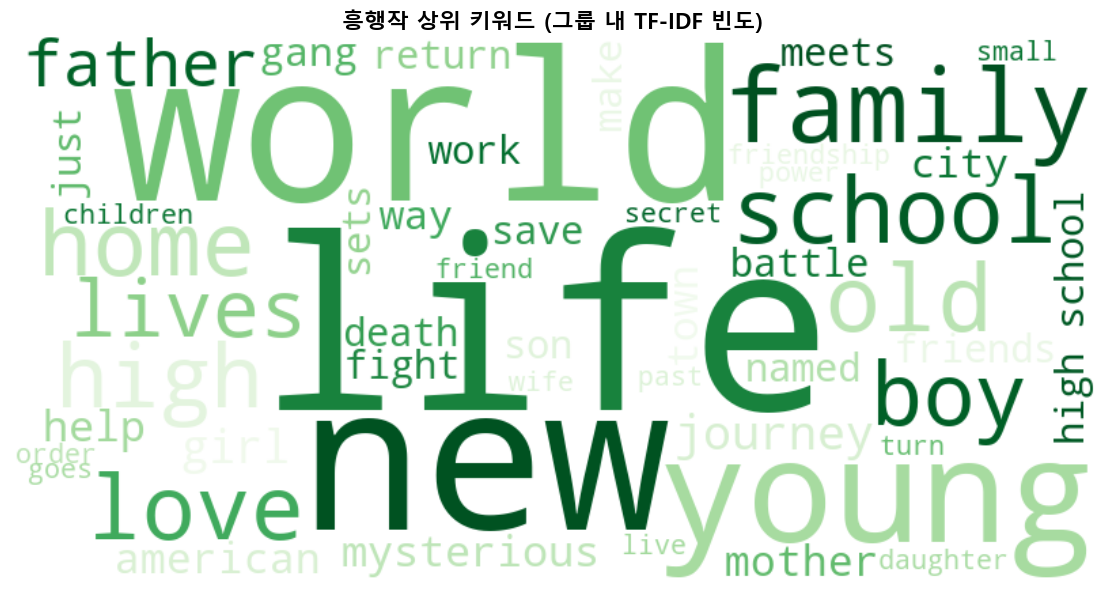

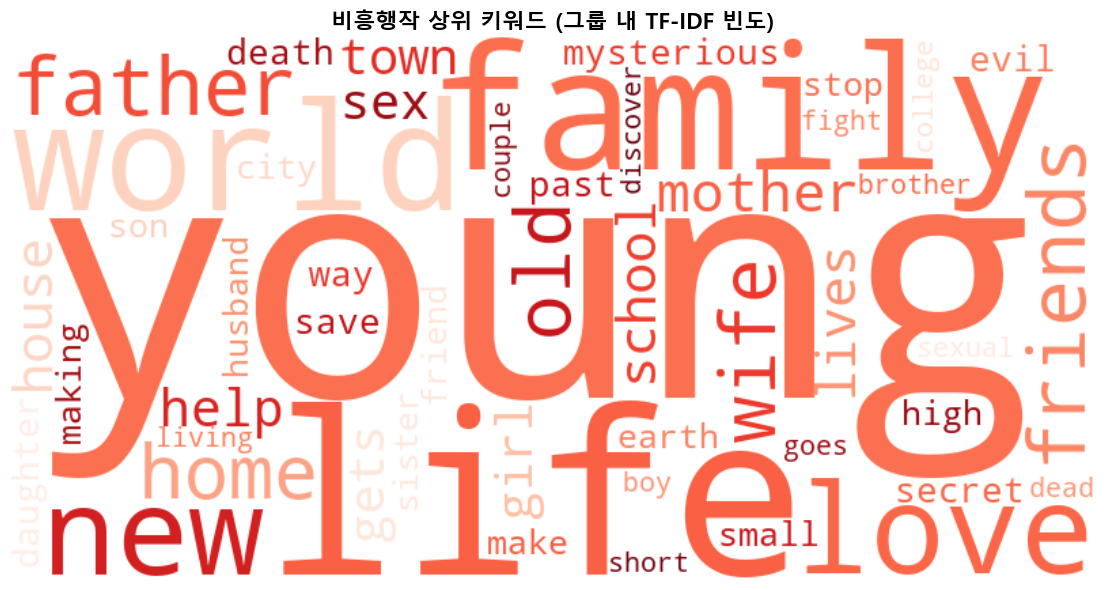

In [71]:
import platform

# 플랫폼별 한글 폰트 설정
system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
elif system == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 1. 흥행작 상위 키워드 워드클라우드
generate_wordcloud(
    hit_top_keywords,
    '흥행작 상위 키워드 (그룹 내 TF-IDF 빈도)',
    'Greens',
    'output/visualization/hit_top_keywords_wordcloud.png'
)

# 2. 비흥행작 상위 키워드 워드클라우드
generate_wordcloud(
    flop_top_keywords,
    '비흥행작 상위 키워드 (그룹 내 TF-IDF 빈도)',
    'Reds',
    'output/visualization/flop_top_keywords_wordcloud.png'
)


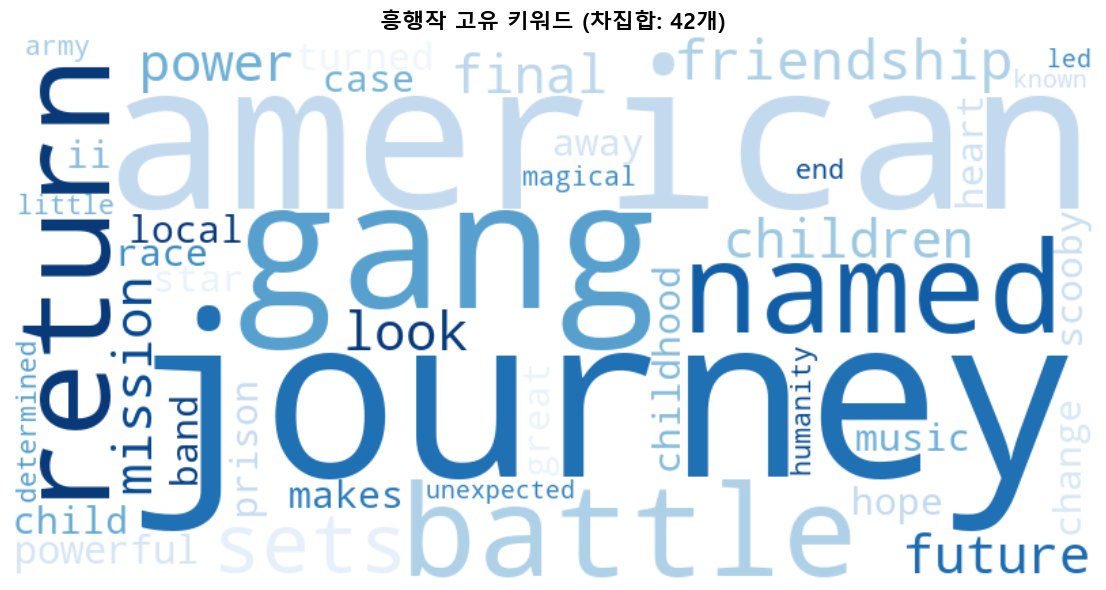

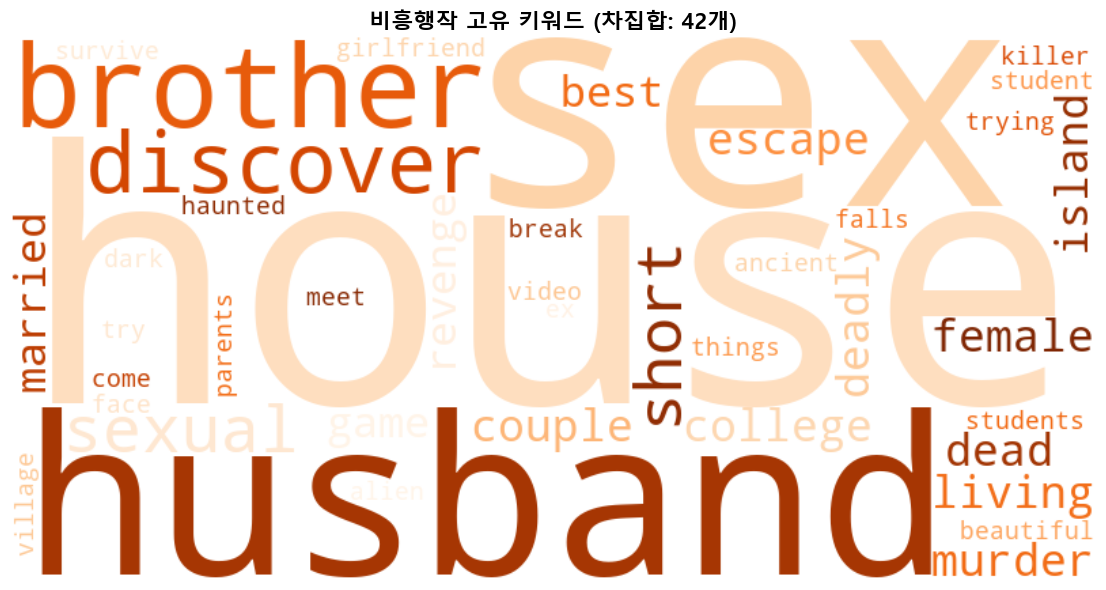


워드클라우드 저장 완료!


In [72]:
# 3. 흥행작 고유 키워드 워드클라우드 (차집합)
if hit_unique_keywords:
    generate_wordcloud(
        hit_unique_keywords,
        f'흥행작 고유 키워드 (차집합: {len(hit_unique_keywords)}개)',
        'Blues',
        'output/visualization/hit_unique_keywords_wordcloud.png'
    )
else:
    print("흥행작 고유 키워드가 없습니다.")

# 4. 비흥행작 고유 키워드 워드클라우드 (차집합)
if flop_unique_keywords:
    generate_wordcloud(
        flop_unique_keywords,
        f'비흥행작 고유 키워드 (차집합: {len(flop_unique_keywords)}개)',
        'Oranges',
        'output/visualization/flop_unique_keywords_wordcloud.png'
    )
else:
    print("비흥행작 고유 키워드가 없습니다.")

print("\n워드클라우드 저장 완료!")

---

# 6. BERTopic 임베딩 모델 로드

## BGE-large-en-v1.5 모델 정보

| 항목 | 값 |
|------|-----|
| 임베딩 차원 | 1024 |
| MTEB 벤치마크 | 64.2점 |
| 모델 크기 | 1.3GB |
| 특징 | 영어 텍스트 최적화, 고성능 |

In [17]:
print("임베딩 모델 로드 중: BAAI/bge-large-en-v1.5")
print("잠시 기다려주세요...")

embedding_model = SentenceTransformer('BAAI/bge-large-en-v1.5')

print(f"모델 로드 완료! 임베딩 차원: {embedding_model.get_sentence_embedding_dimension()}")

임베딩 모델 로드 중: BAAI/bge-large-en-v1.5
잠시 기다려주세요...
모델 로드 완료! 임베딩 차원: 1024


In [27]:
def prepare_embeddings(texts, model):
    """
    텍스트 리스트를 벡터(임베딩)로 변환
    
    Args:
        texts: 변환할 텍스트 리스트
        model: SentenceTransformer 모델
    Returns:
        numpy array (문서 수, 임베딩 차원)
    """
    return model.encode(
        texts,
        show_progress_bar=True,
        batch_size=32,
        normalize_embeddings=True
    )

# 전체 영화 임베딩 생성
print("\n모든 영화에 대한 임베딩 생성 중...")
all_embeddings = prepare_embeddings(df_analysis['text'].tolist(), embedding_model)
print(f"임베딩 shape: {all_embeddings.shape}")

# 흥행/비흥행 임베딩 분리
embeddings_hit = all_embeddings[hit_mask]
embeddings_flop = all_embeddings[flop_mask]

print(f"\n흥행작: {len(df_hit)}편, 임베딩: {embeddings_hit.shape}")
print(f"비흥행작: {len(df_flop)}편, 임베딩: {embeddings_flop.shape}")


모든 영화에 대한 임베딩 생성 중...


Batches: 100%|██████████| 91/91 [01:29<00:00,  1.02it/s]

임베딩 shape: (2896, 1024)

흥행작: 1101편, 임베딩: (1101, 1024)
비흥행작: 1795편, 임베딩: (1795, 1024)


---

# 7. BERTopic 모델 설정

## BERTopic이란?
BERTopic은 BERT 임베딩과 클러스터링을 결합한 토픽 모델링 기법입니다.
문맥적 의미를 반영하여 유사한 문서를 그룹화하고, 각 그룹의 대표 키워드를 추출합니다.

## BERTopic 파이프라인
```
[문서] → [임베딩] → [UMAP 차원축소] → [HDBSCAN 클러스터링] → [c-TF-IDF 키워드 추출]
```

## UMAP 파라미터 (차원 축소)

| 파라미터 | 설명 |
|----------|------|
| n_neighbors | 지역 이웃 수. 작을수록 세밀한 클러스터 |
| n_components | 축소할 차원 수 |
| min_dist | 점 사이 최소 거리. 0에 가까울수록 밀집 |
| metric | 거리 측정 방식 |

## HDBSCAN 파라미터 (클러스터링)

| 파라미터 | 설명 |
|----------|------|
| min_cluster_size | 클러스터 최소 문서 수. 작을수록 토픽 수↑ |
| min_samples | 코어 포인트 최소 이웃 수 |

In [ ]:
# CountVectorizer: BERTopic 내부 c-TF-IDF 계산용
# - 각 토픽(클러스터)별 대표 키워드를 추출할 때 사용
vectorizer_model = CountVectorizer(
    stop_words=english_stopwords,  # 불용어 제거
    ngram_range=(1, 2),            # 1-gram + 2-gram 추출
    min_df=3,                      # 최소 3개 문서에 등장해야 포함
    max_df=0.85                    # 85% 이상 문서에 등장하면 제외
)

def create_bertopic_model(n_neighbors, min_cluster_size):
    """
    BERTopic 모델 생성
    
    Args:
        n_neighbors: UMAP 이웃 수 (작을수록 세밀한 토픽)
        min_cluster_size: HDBSCAN 최소 클러스터 크기 (작을수록 토픽 수 증가)
    """
    return BERTopic(
        # 임베딩 모델 (사전 계산된 임베딩 전달 시 실제로 사용 안 함)
        embedding_model=embedding_model,
        
        # ========== UMAP: 차원 축소 ==========
        # 고차원(1024) → 저차원(5)으로 축소하여 클러스터링 효율화
        umap_model=UMAP(
            # n_neighbors: 각 점 주변의 이웃 수
            # - 작을수록: 지역적 구조 강조 → 세밀한 클러스터
            # - 클수록: 전역적 구조 강조 → 큰 클러스터
            n_neighbors=n_neighbors,
            
            # n_components: 축소할 차원 수
            # - 너무 낮으면 정보 손실, 너무 높으면 클러스터링 어려움
            n_components=5,
            
            # min_dist: 저차원 공간에서 점 사이 최소 거리
            # - 0.0: 밀집된 클러스터 형성 (클러스터링에 적합)
            # - 클수록: 점들이 더 퍼짐
            min_dist=0.0,
            
            # metric: 거리 측정 방식
            # - 'cosine': 텍스트 임베딩에 적합 (방향 유사도)
            metric='cosine',
            
            # random_state: 재현 가능성을 위한 시드
            random_state=42
        ),
        
        # ========== HDBSCAN: 밀도 기반 클러스터링 ==========
        # K-Means와 달리 클러스터 수를 자동으로 결정
        hdbscan_model=HDBSCAN(
            # min_cluster_size: 클러스터로 인정받기 위한 최소 문서 수
            # - 작을수록: 토픽 수 증가, 세분화
            # - 클수록: 토픽 수 감소, 노이즈(outlier) 증가
            min_cluster_size=min_cluster_size,
            
            # min_samples: 코어 포인트가 되기 위한 최소 이웃 수
            # - 밀도 기준 (클수록 더 엄격한 밀도 요구)
            min_samples=3,
            
            # metric: 거리 측정 방식
            # - UMAP 축소 후에는 'euclidean' 사용
            metric='euclidean',
            
            # prediction_data: 새 문서 예측을 위한 데이터 저장
            prediction_data=True
        ),
        
        # c-TF-IDF 키워드 추출용
        vectorizer_model=vectorizer_model,
        
        # 학습 과정 출력
        verbose=True
    )

---

# 8. 흥행작 토픽 분석

In [ ]:
def create_bertopic_model(n_neighbors, min_cluster_size):
    """
    BERTopic 모델 생성
    
    Args:
        n_neighbors: UMAP 이웃 수 (작을수록 세밀한 토픽)
        min_cluster_size: HDBSCAN 최소 클러스터 크기 (작을수록 토픽 수 증가)
    """
    # ========== CountVectorizer 설정 ==========
    # BERTopic 내부에서 c-TF-IDF 계산 시 사용
    # - 각 토픽(클러스터)별 대표 키워드를 추출할 때 사용
    # 
    # ⚠️ 주의: c-TF-IDF는 "토픽별로 합친 문서"에 적용됨
    # - 원본 문서 1000개 → 클러스터링 → 토픽 3개 → 문서 3개로 취급
    # - 따라서 min_df, max_df는 "토픽 수" 기준으로 동작
    # - 토픽이 2개뿐인데 min_df=3이면 에러 발생!
    vectorizer_model = CountVectorizer(
        # 불용어 제거
        stop_words=english_stopwords,
        
        # n-gram 범위: 1-gram + 2-gram 추출
        ngram_range=(1, 2),
        
        # 최소 문서(토픽) 빈도: 1로 고정하여 에러 방지
        # - 토픽 수가 적어도 안전하게 동작
        min_df=1,
        
        # 최대 문서(토픽) 빈도: 95%로 완화
        # - 거의 모든 토픽에 등장하는 단어만 제외
        max_df=0.95
    )
    
    return BERTopic(
        # 임베딩 모델 (사전 계산된 임베딩 전달 시 실제로 사용 안 함)
        embedding_model=embedding_model,
        
        # ========== UMAP: 차원 축소 ==========
        # 고차원(1024) → 저차원(5)으로 축소하여 클러스터링 효율화
        umap_model=UMAP(
            # n_neighbors: 각 점 주변의 이웃 수
            # - 작을수록: 지역적 구조 강조 → 세밀한 클러스터
            # - 클수록: 전역적 구조 강조 → 큰 클러스터
            n_neighbors=n_neighbors,
            
            # n_components: 축소할 차원 수
            # - 너무 낮으면 정보 손실, 너무 높으면 클러스터링 어려움
            n_components=10,
            
            # min_dist: 저차원 공간에서 점 사이 최소 거리
            # - 0.0: 밀집된 클러스터 형성 (클러스터링에 적합)
            # - 클수록: 점들이 더 퍼짐
            min_dist=0.05,
            
            # metric: 거리 측정 방식
            # - 'cosine': 텍스트 임베딩에 적합 (방향 유사도)
            metric='cosine',
            
            # random_state: 재현 가능성을 위한 시드
            random_state=42
        ),
        
        # ========== HDBSCAN: 밀도 기반 클러스터링 ==========
        # K-Means와 달리 클러스터 수를 자동으로 결정
        hdbscan_model=HDBSCAN(
            # min_cluster_size: 클러스터로 인정받기 위한 최소 문서 수
            # - 작을수록: 토픽 수 증가, 세분화
            # - 클수록: 토픽 수 감소, 노이즈(outlier) 증가
            min_cluster_size=min_cluster_size,
            
            # min_samples: 코어 포인트가 되기 위한 최소 이웃 수
            # - 밀도 기준 (클수록 더 엄격한 밀도 요구)
            min_samples=3,
            
            # metric: 거리 측정 방식
            # - UMAP 축소 후에는 'euclidean' 사용
            metric='euclidean',
            
             # cluster_selection_method: 'leaf'로 변경
            # - 'eom' (기본값): 안정적인 큰 클러스터 선호
            # - 'leaf': 가장 세밀한 클러스터 선택 → 토픽 수 증가
            cluster_selection_method='leaf',
            
            # prediction_data: 새 문서 예측을 위한 데이터 저장
            prediction_data=True
        ),
        
        # c-TF-IDF 키워드 추출용
        vectorizer_model=vectorizer_model,
        
        # 학습 과정 출력
        verbose=True
    )

In [ ]:
# ========== 흥행작 토픽 분석 ==========
# 파라미터 설정
hit_n_neighbors = min(10, len(df_hit) - 1)

# min_cluster_size를 더 작게 설정하여 토픽 수 늘리기
# - 기존: len(df_hit) // 30 = 36 → 토픽 2개
# - 수정: len(df_hit) // 100 또는 고정값 15~20 → 토픽 10개 이상 기대
hit_min_cluster = max(15, len(df_hit) // 100)  # 약 11~15

print(f"흥행작 수: {len(df_hit)}")
print(f"UMAP n_neighbors: {hit_n_neighbors}")
print(f"HDBSCAN min_cluster_size: {hit_min_cluster}")

# 모델 생성 및 학습
hit_topic_model = create_bertopic_model(hit_n_neighbors, hit_min_cluster)

print("\n흥행작 BERTopic 모델 학습 중...")
topics_hit, probs_hit = hit_topic_model.fit_transform(
    df_hit['text'].tolist(),
    embeddings=embeddings_hit
)

hit_topic_info = hit_topic_model.get_topic_info()
print(f"\n[흥행작 토픽 개요] - 총 {len(hit_topic_info) - 1}개 토픽")
display(hit_topic_info)

2025-12-09 13:16:27,221 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


흥행작 수: 1101
UMAP n_neighbors: 10
HDBSCAN min_cluster_size: 15

흥행작 BERTopic 모델 학습 중...


2025-12-09 13:16:29,470 - BERTopic - Dimensionality - Completed ✓
2025-12-09 13:16:29,471 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 13:16:29,497 - BERTopic - Cluster - Completed ✓
2025-12-09 13:16:29,499 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 13:16:29,583 - BERTopic - Representation - Completed ✓



[흥행작 토픽 개요] - 총 22개 토픽


,Topic,Count,Name,Representation,Representative_Docs
0,-1,400,-1_life_world_family_old,"[life, world, family, old, boy, lives, school, home, city, love]","[One month after Kayaba Akihiko's game of death began, the death toll continues to rise, two thousand players having already lost their lives to the ultra-difficult VRMMO world of Sword Art Online. On the day of the strategy meeting to plan out the first-floor boss battle, Kirito, a solo player who vows to fight alone to get stronger, runs into a rare, high-level female player. She gracefully dispatches powerful monsters with a single rapier that flashes like a shooting star in the night..., Maquia is a member of a special race called the Iorph who can live for hundreds of years. However, Maquia has always felt lonely despite being surrounded by her people, as she was orphaned from a young age. She daydreams about the outside world, but dares not travel from her home due to the warnings of the clan's chief. One day the kingdom of Mezarte invades her homeland. They already have what is left of the giant dragons, the Renato, under their control, and now their king wishes to add the immortality to his bloodline. They ravage the Iorph homeland and kill most of its inhabitants. Caught in the midst of the attack, Maquia is carried off by one of the Renato. It soon dies, and she is left deserted in a forest, now truly alone save for the cries of a single baby off in the distance. Maquia finds the baby in a destroyed village and decides to raise him as her own, naming him Ariel. Although she knows nothing of the human world, how to raise a child that ages much faster than her., In January 1987, a 22-year-old college student dies during a police interrogation. Under the orders of Director Park, the police request the body to be cremated in order to destroy evidence. Public Prosecutor Choi, who was on duty on the day of the incident, denies the request and calls for an autopsy. The police maintain the lie that the death was a simple accident, resulting from shock. The autopsy results, however, point to torture as the cause of death. Yoon, a journalist following the case, reports that the death was a result of asphyxiation during torture. Director Park attempts to conceal the truth by ending the case, arresting two detectives including inspector Cho. While in prison, inspector Cho reveals the truth to prison guard Han Byung-yong, who embarks on a dangerous mission to relay the information to an opposition politician through his niece, Yeon-hee.]"
1,0,61,0_police_heist_case_mafia,"[police, heist, case, mafia, frank, drug, detective, family, mr, corleone]","[Driver is a skilled Hollywood stuntman who moonlights as a getaway driver for criminals. Though he projects an icy exterior, lately he's been warming up to a pretty neighbor named Irene and her young son, Benicio. When Irene's husband gets out of jail, he enlists Driver's help in a million-dollar heist. The job goes horribly wrong, and Driver must risk his life to protect Irene and Benicio from the vengeful masterminds behind the robbery., After getting a green card in exchange for assassinating a Cuban government official, Tony Montana stakes a claim on the drug trade in Miami. Viciously murdering anyone who stands in his way, Tony eventually becomes the biggest drug lord in the state, controlling nearly all the cocaine that comes through Miami. But increased pressure from the police, wars with Colombian drug cartels and his own drug-fueled paranoia serve to fuel the flames of his eventual downfall., Mags, a hot-headed pizza delivery cyclist who reckons herself to be entirely self-sufficient, is just about getting by during the property crisis in Dublin. When her bike is stolen and she loses her job, her eviction seems inevitable. With nowhere else to go, Mags must hunt down the thief who stole her bike and steal it right back. Mags must overcome her aversion to asking for help if she’s going to succeed, because this is no ordinary 

## BERTopic 결과 해석

### 1. Topic -1의 의미

| Topic | 의미 |
|-------|------|
| **-1** | **Outlier (이상치)** - 어느 토픽에도 속하지 않는 문서들 |
| 0, 1, 2, ... | 실제 의미 있는 토픽 |

- HDBSCAN은 밀도 기반 클러스터링이라 **어디에도 속하지 않는 문서**를 -1로 분류
- 400개가 outlier라는 건 해당 문서들이 다른 문서들과 유사하지 않다는 의미
- outlier가 많으면 `min_cluster_size`를 줄이거나 `min_samples`를 낮춰볼 수 있음

### 3. 각 컬럼 설명

| 컬럼 | 설명 | 예시 해석 |
|------|------|----------|
| **Topic** | 토픽 번호 (-1은 outlier) | `6` = 6번 토픽 |
| **Count** | 해당 토픽에 속한 문서(영화) 수 | `37` = 37편의 영화 |
| **Name** | 토픽 자동 명명 (상위 키워드 조합) | `6_interviews_look_intimate_making` |
| **Representation** | 토픽 대표 키워드 리스트 (c-TF-IDF 기준) | `[interviews, look, intimate, making, ...]` |
| **Representative_Docs** | 해당 토픽을 가장 잘 대표하는 문서(줄거리) | 실제 영화 줄거리 텍스트 |

In [48]:
# 토픽별 키워드 출력
print("[흥행작 토픽별 키워드]")
print("=" * 60)

for topic_id in sorted(hit_topic_info['Topic'].unique()):
    if topic_id != -1:
        keywords = hit_topic_model.get_topic(topic_id)
        count = hit_topic_info[hit_topic_info['Topic'] == topic_id]['Count'].values[0]
        
        print(f"\n📌 토픽 {topic_id} ({count}편)")
        print("-" * 40)
        for word, score in keywords[:7]:
            print(f"  {word}: {score:.4f}")

# 토픽 할당 및 통계
df_hit['topic'] = topics_hit

print("\n[흥행작 토픽별 통계]")
hit_stats = df_hit[df_hit['topic'] != -1].groupby('topic').agg({
    'vote_average': ['mean', 'std', 'count'],
    'title': lambda x: ', '.join(x.head(3))
}).round(2)
hit_stats.columns = ['평균평점', '표준편차', '영화수', '샘플영화']

display(hit_stats)

[흥행작 토픽별 키워드]

📌 토픽 0 (61편)
----------------------------------------
  police: 0.0174
  heist: 0.0171
  case: 0.0154
  mafia: 0.0136
  frank: 0.0128
  drug: 0.0121
  detective: 0.0119

📌 토픽 1 (59편)
----------------------------------------
  demon: 0.0194
  saints: 0.0146
  athena: 0.0132
  naruto: 0.0119
  sakura: 0.0119
  inuyasha: 0.0119
  evil: 0.0115

📌 토픽 2 (48편)
----------------------------------------
  scooby: 0.0408
  gang: 0.0357
  doo: 0.0264
  scooby doo: 0.0264
  shaggy: 0.0235
  monster: 0.0232
  monster high: 0.0206

📌 토픽 3 (47편)
----------------------------------------
  love: 0.0198
  falls: 0.0174
  coach: 0.0165
  daughter: 0.0157
  screenwriter: 0.0148
  make: 0.0146
  life: 0.0146

📌 토픽 4 (44편)
----------------------------------------
  alien: 0.0169
  earth: 0.0159
  space: 0.0154
  planet: 0.0139
  kolya: 0.0130
  nuclear: 0.0130
  empire: 0.0130

📌 토픽 5 (42편)
----------------------------------------
  nazi: 0.0248
  world ii: 0.0221
  ii: 0.0212
  world: 0.0207


,평균평점,표준편차,영화수,샘플영화
topic,,,,
0,7.91,0.42,61,"Wrath of Man, The Wolf of Wall Street, The Bad Guys"
1,7.80,0.37,59,"Demon Slayer -Kimetsu no Yaiba- The Movie: Mugen Train, Demon Slayer: Kimetsu no Yaiba - Sibling's Bond, Laid-Back Camp the Movie"
2,7.77,0.37,48,"Sing 2, Unicorn Wars, Monsters, Inc."
3,7.89,0.45,47,"The Whale, Overcomer, The Man from Earth"
4,7.85,0.41,44,"John Wick: Chapter 4, Sniper: The White Raven, Avatar"
5,7.83,0.27,42,"All Quiet on the Western Front, RRR, Fury"
6,8.22,0.67,37,"Top Gun: Maverick, Selena Gomez: My Mind & Me, Resident Evil Damnation: The DNA of Damnation"
7,7.95,0.42,36,"Puss in Boots: The Last Wish, Little Eggs: A Frozen Rescue, Finding Nemo"
8,7.84,0.34,34,"The Roundup, Just Mercy, Valley of the Dead"


## 흥행작 토픽 상세 해석

### 📊 전체 요약

| 구분 | 토픽 수 | 영화 수 | 비율 |
|------|--------|--------|------|
| Outlier (-1) | 1개 | 400편 | 36% |
| 실제 토픽 (0~21) | 22개 | 701편 | 64% |

> **Outlier가 36%인 이유**: 다양한 장르/테마의 영화들이 뚜렷한 클러스터를 형성하지 못함

---

### 🎬 AI의 토픽별 상세 해석 결과

| 토픽 | 장르/테마 | 영화수 | 평점 | 핵심 키워드 | 대표작 |
|------|-----------|--------|------|-------------|--------|
| **0** | 🚔 범죄/수사/마피아 | 61편 | 7.91 | police, heist, mafia, detective | Wrath of Man, The Wolf of Wall Street, The Bad Guys |
| **1** | 👹 일본 배틀 애니 | 59편 | 7.80 | demon, naruto, inuyasha, saints | Demon Slayer: Mugen Train, Laid-Back Camp the Movie |
| **2** | 🎭 애니메이션 코미디 | 48편 | 7.77 | scooby, monster high, shaggy | Sing 2, Unicorn Wars, Monsters, Inc. |
| **3** | 💕 로맨스/인생 드라마 | 47편 | 7.89 | love, falls, daughter, change | The Whale, Overcomer, The Man from Earth |
| **4** | 🚀 SF/액션 | 44편 | 7.85 | alien, earth, space, planet | John Wick: Chapter 4, Sniper: The White Raven, Avatar |
| **5** | ⚔️ 2차 세계대전 | 42편 | 7.83 | nazi, world ii, british, soldiers | All Quiet on the Western Front, RRR, Fury |
| **6** | 🎬 다큐/메이킹필름 | 37편 | **8.22**⭐ | interviews, intimate, making, music | Top Gun: Maverick, Selena Gomez: My Mind & Me |
| **7** | 🐶 동물/가족 애니 | 36편 | 7.95 | dog, babies, friendship, desert | Puss in Boots: The Last Wish, Finding Nemo |
| **8** | 🤠 서부/소도시 드라마 | 34편 | 7.84 | town, sheriff, bounty, small | The Roundup, Just Mercy, Valley of the Dead |
| **9** | 👵 가족/세대 드라마 | 33편 | 7.90 | old, mother, sisters, ship | Luck, Coraline, Tangled |
| **10** | 🏫 학원 로맨스 | 30편 | 7.80 | love, school, high school, senior | Life in a Year, 20th Century Girl, Close |
| **11** | 🇰🇷 한국/스페인 가족물 | 27편 | **8.01** | jin seong, sister, soo, javier | Girl in the Basement, Padre no hay más que uno 3 |
| **12** | 🦸 슈퍼히어로 | 25편 | 7.84 | spider, avengers, justice league | Spider-Man: No Way Home, Avengers: Infinity War |
| **13** | 🏎️ 레이싱/실화 드라마 | 24편 | **8.01** | car, driver, race car, century | Ford v Ferrari, Gifted Hands, The Grand Budapest Hotel |
| **14** | ✝️ 종교/성경 | 23편 | **8.05** | jesus, god, ministry, solomon | The Passion of the Christ, The Ten Commandments |
| **15** | 👧 미스터리/공포 | 21편 | 7.75 | girl, grace, mysterious, entity | The Exorcist, A Man Called Otto, Malvada |
| **16** | 🤖 일본 액션 애니 | 21편 | 7.79 | evangelion, kenshin, goku, fight | Dragon Ball Super, Mortal Kombat, Rurouni Kenshin |
| **17** | 💗 일본 로맨스 애니 | 20편 | 8.00 | feelings, hina, love, high school | A Silent Voice, Josee the Tiger and the Fish |
| **18** | 🇲🇽 라틴 가족/종교 | 19편 | 7.83 | father, leo, miguel, el, san | Coco, The Emperor's New Groove |
| **19** | 🙏 신앙/감동 실화 | 19편 | 7.84 | life, pastor, deaf, faith | Gifted, I Can Only Imagine, Courageous |
| **20** | 🏠 귀향/가족 재회 | 16편 | 7.88 | returns home, brother, past | The Incredibles, Forever My Girl |
| **21** | ⚡ 해리포터/판타지 | 15편 | 7.94 | harry, hogwarts, wizard, ring | Harry Potter 시리즈 전편 |

---

### 🏆 핵심 인사이트

#### 1. 평점 TOP 5 토픽

| 순위 | 토픽 | 평점 | 특징 |
|------|------|------|------|
| 1위 | 토픽 6 (다큐/메이킹) | **8.22** | 진정성 있는 콘텐츠가 최고 평점 |
| 2위 | 토픽 14 (종교/성경) | **8.05** | 종교적 메시지 + 서사적 스케일 |
| 3위 | 토픽 11 (한국/스페인 가족) | **8.01** | 가족 관계 중심 감동 드라마 |
| 3위 | 토픽 13 (레이싱/실화) | **8.01** | 실화 기반 열정/도전 스토리 |
| 5위 | 토픽 17 (일본 로맨스 애니) | **8.00** | 섬세한 감정 묘사 |

#### 2. 흥행작 장르 분포

```
일본 애니메이션: 토픽 1, 2, 16, 17 → 148편 (21%)
실화/다큐: 토픽 6, 13, 14, 19 → 103편 (15%)
가족/로맨스: 토픽 3, 9, 10, 11, 20 → 153편 (22%)
액션/SF: 토픽 0, 4, 5, 8, 12 → 206편 (29%)
판타지/공포: 토픽 15, 21 → 36편 (5%)
```

#### 3. 흥행 성공 공식

| 요소 | 설명 | 해당 토픽 |
|------|------|----------|
| **진정성** | 다큐, 실화, 신앙 | 6, 13, 14, 19 |
| **프랜차이즈** | 기존 팬덤 확보 | 1, 2, 12, 21 |
| **보편적 감정** | 사랑, 가족, 성장 | 3, 9, 10, 17, 20 |
| **스펙터클** | 액션, SF, 전쟁 | 0, 4, 5, 8 |

---

# 9. 비흥행작 토픽 분석

In [49]:
# 파라미터 설정
flop_n_neighbors = min(10, len(df_flop) - 1)
flop_min_cluster = max(10, len(df_flop) // 30)

print(f"UMAP n_neighbors: {flop_n_neighbors}")
print(f"HDBSCAN min_cluster_size: {flop_min_cluster}")

# 모델 생성 및 학습
flop_topic_model = create_bertopic_model(flop_n_neighbors, flop_min_cluster)

print("\n비흥행작 BERTopic 모델 학습 중...")
topics_flop, probs_flop = flop_topic_model.fit_transform(
    df_flop['text'].tolist(),
    embeddings=embeddings_flop
)

# 토픽 개요
flop_topic_info = flop_topic_model.get_topic_info()
print(f"\n[비흥행작 토픽 개요] - 총 {len(flop_topic_info) - 1}개 토픽")
display(flop_topic_info)

2025-12-09 13:19:46,304 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP n_neighbors: 10
HDBSCAN min_cluster_size: 59

비흥행작 BERTopic 모델 학습 중...


2025-12-09 13:19:51,598 - BERTopic - Dimensionality - Completed ✓
2025-12-09 13:19:51,598 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 13:19:51,646 - BERTopic - Cluster - Completed ✓
2025-12-09 13:19:51,648 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 13:19:51,773 - BERTopic - Representation - Completed ✓



[비흥행작 토픽 개요] - 총 8개 토픽


,Topic,Count,Name,Representation,Representative_Docs
0,-1,730,-1_love_friends_old_father,"[love, friends, old, father, wife, help, lives, sex, past, brother]","[James and Carl were only 10 years old when they kidnapped and murdered 3 year old David McClendon. They were caught, tried, convicted and placed in separate juvenile facilities. At 18-years old, both are given new names and released back into society - much to the horror of the nation. They can have no contact with each other or with their past friends or relatives. The story follows the lives of these two boys as they try to start over, escape the past and survive the growing outcry following their release., Sex is currency. It commands power and can instill fear. Tom, a young man with a troubled past finds himself sucked into a seedy underworld by George Norris, a now super villain with a sadistic streak. A helpless pawn in one of Norris's narcotic scams with a bent cop, Dunston, Tom is dragged deeper into a vicious circle of blood money, vice and ruthless violence from which their seems no way out. Until fate gives Tom a glimmer of hope. When Norris is killed in his apartment, Tom seizes his chance to escape. Terrified and covered in Norris's blood, Tom heads downstairs to his neighbors, Max and Nikki his new friends in the city. With going to the police out of the question, Max and Nikki speed Tom to their desolate cottage deep in the Welsh countryside. With the luxury of space, Tom begins to realize a long-forgotten dream; a return to happier times before his innocence was shattered. Suppressed emotion flood back provoked by Tom's attraction to Nikki..., The story is of three friends from school who meet up after about 18 years. One of them is a successful businessman, the other runs his in laws business and third one is a writer with a writers block. He asks old friends to help. In the process the three get back some fun of the past. But as they can't help the writer and some strange things keep occurring the three friends quarrel. But then the writer gets a clue and the three friends embark on a journey. In the strange place they land up, the three keep meeting people who are look alike from their past. Initially they try to reason, but finally as all three get involved and remember the stories involving these look alike the three start fretting. They are uncomfortable and worried - Disturbed. And this disturbance, distress, confusion, turmoil . It's their past present and future all rolled into each other..Their mind is in a mess - Old memories comes back haunting them.]"
1,0,235,0_evil_haunted_house_mysterious,"[evil, haunted, house, mysterious, friends, old, students, children, terrifying, past]","[Three friends decide to play The Red Book game. What they don't know is that in the house evil is waiting to be released. A long time ago a witch died as part of a satanic ritual. Every question they ask, they get closer and closer to her. The book will reveal the answers to all your questions… but what if your host is an evil entity with a thirst for blood?, Starting a new life in a quiet Pennsylvania town, Matthew Michaels only thought is to turn an old farm property into a profitable car dealership. He soon discovers that beneath the gentle surface, this small town is anything but calm and peaceful. Firstly, he learns that his new property is located on the site of a graveyard, which all the townsfolk regard as an evil place that must never be visited. He then discovers that years earlier the town had suffered an infestation of the living dead ...zombies who prey on human flesh. One zombie, the infamous Abbot Hayes, escaped destruction. As the construction team begin degging, they unleash the thing the townsfolk fear the most, the wrath of Abbot Hayes and the awakening of ... The Children of the Living Dead., On a night of teenage partying in the woods, Paige unwittingly sets in motion a chain of events that plunge her into a waking nightmare. Tormented by terri

In [50]:
# 토픽별 키워드 출력
print("[비흥행작 토픽별 키워드]")
print("=" * 60)

for topic_id in sorted(flop_topic_info['Topic'].unique()):
    if topic_id != -1:
        keywords = flop_topic_model.get_topic(topic_id)
        count = flop_topic_info[flop_topic_info['Topic'] == topic_id]['Count'].values[0]
        
        print(f"\n📌 토픽 {topic_id} ({count}편)")
        print("-" * 40)
        for word, score in keywords[:7]:
            print(f"  {word}: {score:.4f}")

# 토픽 할당 및 통계
df_flop['topic'] = topics_flop

print("\n[비흥행작 토픽별 통계]")
flop_stats = df_flop[df_flop['topic'] != -1].groupby('topic').agg({
    'vote_average': ['mean', 'std', 'count'],
    'title': lambda x: ', '.join(x.head(3))
}).round(2)
flop_stats.columns = ['평균평점', '표준편차', '영화수', '샘플영화']
display(flop_stats)

[비흥행작 토픽별 키워드]

📌 토픽 0 (235편)
----------------------------------------
  evil: 0.0153
  haunted: 0.0140
  house: 0.0134
  mysterious: 0.0120
  friends: 0.0116
  old: 0.0111
  students: 0.0104

📌 토픽 1 (225편)
----------------------------------------
  earth: 0.0218
  alien: 0.0147
  planet: 0.0138
  shark: 0.0123
  fight: 0.0117
  mission: 0.0106
  survivors: 0.0103

📌 토픽 2 (128편)
----------------------------------------
  short: 0.0295
  making: 0.0222
  live: 0.0176
  featuring: 0.0130
  project: 0.0119
  interviews: 0.0117
  filmmaker: 0.0108

📌 토픽 3 (125편)
----------------------------------------
  hee: 0.0322
  soo: 0.0296
  jin: 0.0277
  min: 0.0264
  joo: 0.0230
  yeong: 0.0216
  jae: 0.0211

📌 토픽 4 (109편)
----------------------------------------
  sexual: 0.0216
  love: 0.0209
  sex: 0.0189
  wife: 0.0171
  summer: 0.0149
  college: 0.0139
  video: 0.0136

📌 토픽 5 (87편)
----------------------------------------
  police: 0.0160
  heist: 0.0160
  agent: 0.0153
  help: 0.0146
  secur

,평균평점,표준편차,영화수,샘플영화
topic,,,,
0,4.07,1.88,235,"The Secret Mummies of Lisbon, Winnie the Pooh: Blood and Honey, H.P. Lovecraft's Witch House"
1,4.38,1.49,225,"Shark Side of the Moon, Arctic Void, Crawlspace"
2,0.98,1.94,128,"Dolphin Boy, Project Gemini: A Bold Leap Forward, Beastie Boys: The $kill$ To Pay The Bill$"
3,3.81,1.70,125,"Suzume Lovely Tropical Bird, Marudase Kintarou, Beauty Salon: Special Service 3"
4,4.01,1.68,109,"The Library Boys, Sinner: The Secret Diary of a Nymphomaniac, The Bush"
5,4.45,1.67,87,"Detective Knight: Independence, Superfast!, Bullet Proof"
6,3.51,2.13,83,"Lord of the Streets, Dracula: The Original Living Vampire, Dungeons & Dragons: Wrath of the Dragon God"
7,4.21,1.85,73,"The Crazy Instructor, Hatching Pete, Beverly Hills Chihuahua"


## 비흥행작 토픽 상세 해석

### 📊 전체 요약

| 구분 | 토픽 수 | 영화 수 | 비율 |
|------|--------|--------|------|
| Outlier (-1) | 1개 | 730편 | **58%** |
| 실제 토픽 (0~7) | 8개 | 530편 | 42% |

> **Outlier가 58%로 매우 높은 이유**: 비흥행작들은 품질이 낮고 서사 구조가 불분명하여 일관된 패턴을 형성하지 못함

---

### AI의 토픽별 상세 해석

| 토픽 | 장르/테마 | 영화수 | 평점 | 핵심 키워드 | 대표작 |
|------|-----------|--------|------|-------------|--------|
| **0** | 👻 저예산 공포/호러 | 235편 | 4.07 | evil, haunted, house, mysterious | Winnie the Pooh: Blood and Honey, H.P. Lovecraft's Witch House |
| **1** | 👽 B급 SF/괴물 | 225편 | 4.38 | earth, alien, planet, shark | Shark Side of the Moon, Arctic Void, Crawlspace |
| **2** | 🎥 저예산 다큐/단편 | 128편 | **0.98**⚠️ | short, making, interviews, filmmaker | Dolphin Boy, Project Gemini, Beastie Boys |
| **3** | 🇰🇷 한국 성인물 | 125편 | 3.81 | hee, soo, jin, min, joo | Marudase Kintarou, Beauty Salon: Special Service 3 |
| **4** | 🔞 성인/에로틱 | 109편 | 4.01 | sexual, love, sex, wife, summer | The Library Boys, Sinner: Diary of a Nymphomaniac |
| **5** | 🔫 저예산 액션/범죄 | 87편 | 4.45 | police, heist, agent, cia | Detective Knight, Superfast!, Bullet Proof |
| **6** | 🥋 B급 액션/복수극 | 83편 | 3.51 | assassin, detective, murder, master | Lord of the Streets, Dracula, Dungeons & Dragons |
| **7** | 🧚 저예산 가족/판타지 | 73편 | 4.21 | fairy, evil, magic, timmy | The Crazy Instructor, Hatching Pete, Beverly Hills Chihuahua |

---

### 🔍 비흥행작 특징 분석

#### 1. 평점 분포

| 순위 | 토픽 | 평점 | 특징 |
|------|------|------|------|
| 최저 | 토픽 2 (저예산 다큐) | **0.98** | 미완성/아마추어 프로젝트 |
| 하위 | 토픽 6 (B급 액션) | **3.51** | 저예산 + 클리셰 서사 |
| 하위 | 토픽 3 (한국 성인물) | **3.81** | 스토리보다 자극적 요소 |
| 상위 | 토픽 5 (액션/범죄) | **4.45** | 그나마 장르 문법 준수 |

#### 2. 비흥행 원인별 분류

| 원인 | 해당 토픽 | 설명 |
|------|----------|------|
| **저예산/B급** | 0, 1, 6, 7 | 제작비 부족 → 완성도 저하 |
| **성인/자극적** | 3, 4 | 스토리 부재, 특정 타겟만 공략 |
| **미완성/실험적** | 2 | 다큐/단편 중 품질 미달 |
| **장르 클리셰** | 0, 1, 5, 6 | 식상한 전개, 차별화 실패 |

---

### ⚠️ 흥행작 vs 비흥행작 비교

| 항목 | 흥행작 | 비흥행작 |
|------|--------|----------|
| **토픽 수** | 22개 | 8개 |
| **Outlier 비율** | 36% | **58%** |
| **평균 평점** | 7.75~8.22 | 0.98~4.45 |
| **공포/SF** | 의미 있는 서사 | B급/저예산 |
| **다큐멘터리** | 최고 평점 (8.22) | 최저 평점 (0.98) |
| **성인물** | 거의 없음 | 2개 토픽 (234편) |

---

### 💡 핵심 인사이트

#### 비흥행작의 공통점

```
1. 🎬 저예산 제작 → 완성도 부족
2. 📝 스토리 부재 → 자극적 요소에 의존
3. 🔄 장르 클리셰 → 차별화 실패
4. 🎯 틈새시장 공략 → 대중성 부족
```

#### B급 영화의 함정

| 장르 | 흥행작 접근법 | 비흥행작 접근법 |
|------|--------------|----------------|
| **공포** | 심리적 공포, 서사적 긴장 | 점프스케어, 고어에 의존 |
| **SF** | 세계관 구축, 철학적 메시지 | 싸구려 CG, 괴물 나열 |
| **액션** | 캐릭터 성장, 감정선 | 폭력 장면 나열 |
| **다큐** | 진정성, 깊이 있는 취재 | 미완성, 아마추어 |

#### 성인물 토픽 (3, 4)의 특징

- 한국어 이름(희, 수, 진, 민) → 한국 성인영화 다수 포함
- 스토리보다 **자극적 요소**에 집중
- 평점 3.81~4.01로 전체적으로 낮음
- 총 234편으로 비흥행작의 **19%** 차지

---

# 10. BERTopic 분석 결과 시각화

In [73]:
# ========== 흥행작 토픽 바 차트 ==========
try:
    fig_hit_bar = hit_topic_model.visualize_barchart(
        top_n_topics=10,   # 상위 10개 토픽 표시
        n_words=8          # 토픽당 8개 키워드 표시
    )
    
    # 제목 및 레이아웃 커스터마이징
    fig_hit_bar.update_layout(
        title={
            'text': '흥행작 토픽별 키워드 중요도 (c-TF-IDF)',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18, 'color': 'darkgreen'}
        },
        paper_bgcolor='white',
        plot_bgcolor='#f8fff8',
        showlegend=False
    )
    
    # 바 색상 변경 (녹색 계열)
    fig_hit_bar.update_traces(marker_color='seagreen')
    
    fig_hit_bar.write_html(f"{output_dir}/hit_topics_barchart.html")
    fig_hit_bar.show()
    print(f"저장: {output_dir}/hit_topics_barchart.html")
    
except Exception as e:
    print(f"흥행작 바 차트 오류: {e}")

#%%
# ========== 비흥행작 토픽 바 차트 ==========
try:
    fig_flop_bar = flop_topic_model.visualize_barchart(
        top_n_topics=10,
        n_words=8
    )
    
    # 제목 및 레이아웃 커스터마이징
    fig_flop_bar.update_layout(
        title={
            'text': '비흥행작 토픽별 키워드 중요도 (c-TF-IDF)',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18, 'color': 'darkred'}
        },
        paper_bgcolor='white',
        plot_bgcolor='#fff8f8',
        showlegend=False
    )
    
    # 바 색상 변경 (빨강 계열)
    fig_flop_bar.update_traces(marker_color='indianred')
    
    fig_flop_bar.write_html(f"{output_dir}/flop_topics_barchart.html")
    fig_flop_bar.show()
    print(f"저장: {output_dir}/flop_topics_barchart.html")
    
except Exception as e:
    print(f"비흥행작 바 차트 오류: {e}")

저장: output/visualization/hit_topics_barchart.html


저장: output/visualization/flop_topics_barchart.html


In [75]:
# 토픽 간 거리 시각화 (커스터마이징)

# ========== 흥행작 토픽 맵 ==========
try:
    fig_hit_map = hit_topic_model.visualize_topics()
    
    # 제목 추가 및 레이아웃 수정
    fig_hit_map.update_layout(
        title={
            'text': '흥행작 토픽 간 거리 시각화 (Intertopic Distance Map)',
            'x': 0.5,           # 제목 가운데 정렬
            'xanchor': 'center',
            'font': {'size': 18, 'color': 'darkgreen'}
        },
        paper_bgcolor='white',   # 배경색
        plot_bgcolor='#f0f8f0',  # 플롯 영역 배경 (연한 녹색)
    )
    
    # 마커 색상 테마 변경 (녹색 계열)
    fig_hit_map.update_traces(
        marker=dict(
            color='green',
            line=dict(color='darkgreen', width=2)
        )
    )
    
    fig_hit_map.write_html("output/visualization/hit_topics_map.html")
    fig_hit_map.show()
    print("저장: hit_topics_map.html")
    
except Exception as e:
    print(f"흥행작 토픽 맵 오류: {e}")


# ========== 비흥행작 토픽 맵 ==========
try:
    fig_flop_map = flop_topic_model.visualize_topics()
    
    # 제목 추가 및 레이아웃 수정
    fig_flop_map.update_layout(
        title={
            'text': '비흥행작 토픽 간 거리 시각화 (Intertopic Distance Map)',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18, 'color': 'darkred'}
        },
        paper_bgcolor='white',
        plot_bgcolor='#fff0f0',  # 플롯 영역 배경 (연한 빨강)
    )
    
    # 마커 색상 테마 변경 (빨강 계열)
    fig_flop_map.update_traces(
        marker=dict(
            color='red',
            line=dict(color='darkred', width=2)
        )
    )
    
    fig_flop_map.write_html("output/visualization/flop_topics_map.html")
    fig_flop_map.show()
    print("저장: flop_topics_map.html")
    
except Exception as e:
    print(f"비흥행작 토픽 맵 오류: {e}")

저장: hit_topics_map.html


저장: flop_topics_map.html


In [ ]:
# ========== 토픽 간 거리 기반 클러스터 분석 (유사 토픽 통합)========== 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

def analyze_topic_clusters(topic_model, n_groups, label=""):
    """
    토픽 간 거리를 계산하고 유사한 토픽끼리 그룹화
    
    Args:
        topic_model: 학습된 BERTopic 모델
        n_groups: 원하는 그룹 수
        label: 출력 시 표시할 라벨 (흥행작/비흥행작)
    
    Returns:
        topic_clusters: 토픽별 클러스터 정보 DataFrame
    """
    # 토픽 임베딩(좌표) 추출
    topic_embeddings = topic_model.topic_embeddings_
    
    # 토픽 정보 (outlier -1 제외)
    topic_info = topic_model.get_topic_info()
    valid_topics = topic_info[topic_info['Topic'] != -1]['Topic'].tolist()
    
    # outlier(-1)는 인덱스 0에 있으므로, 실제 토픽은 인덱스 1부터
    valid_embeddings = topic_embeddings[1:len(valid_topics)+1]
    
    print(f"\n{'='*70}")
    print(f"📊 {label} 토픽 클러스터 분석")
    print(f"{'='*70}")
    print(f"토픽 수: {len(valid_topics)}개, 그룹 수: {n_groups}개")
    
    # 계층적 클러스터링
    clustering = AgglomerativeClustering(
        n_clusters=n_groups,
        metric='cosine',
        linkage='average'
    )
    cluster_labels = clustering.fit_predict(valid_embeddings)
    
    # 결과 정리
    topic_clusters = pd.DataFrame({
        '토픽번호': valid_topics,
        '클러스터': cluster_labels,
        '영화수': [topic_info[topic_info['Topic'] == t]['Count'].values[0] for t in valid_topics],
        '키워드': [', '.join([w for w, s in topic_model.get_topic(t)[:3]]) for t in valid_topics]
    })
    
    # 클러스터별 출력
    print(f"\n[유사 토픽 그룹]")
    
    for cluster_id in sorted(topic_clusters['클러스터'].unique()):
        cluster_topics = topic_clusters[topic_clusters['클러스터'] == cluster_id]
        topic_nums = cluster_topics['토픽번호'].tolist()
        total_movies = cluster_topics['영화수'].sum()
        
        print(f"\n📌 그룹 {cluster_id}: 토픽 {topic_nums} (총 {total_movies}편)")
        print("-" * 50)
        
        for _, row in cluster_topics.iterrows():
            print(f"   토픽 {row['토픽번호']:2d} ({row['영화수']:3d}편): {row['키워드']}")
    
    # 클러스터별 요약
    cluster_summary = topic_clusters.groupby('클러스터').agg({
        '토픽번호': lambda x: list(x),
        '영화수': 'sum'
    }).reset_index()
    cluster_summary.columns = ['클러스터', '포함_토픽', '총_영화수']
    
    print(f"\n[클러스터 요약]")
    display(cluster_summary)
    
    return topic_clusters


# ========== 흥행작 토픽 클러스터 분석 ==========
# 시각화에서 보이는 뭉침 수에 맞게 n_groups 조정
hit_topic_clusters = analyze_topic_clusters(
    topic_model=hit_topic_model,
    n_groups=5,  # 시각화에서 약 5개 그룹으로 보임
    label="흥행작"
)


# ========== 비흥행작 토픽 클러스터 분석 ==========
flop_topic_clusters = analyze_topic_clusters(
    topic_model=flop_topic_model,
    n_groups=3,  # 시각화에서 약 3개 그룹으로 보임
    label="비흥행작"
)


📊 흥행작 토픽 클러스터 분석
토픽 수: 22개, 그룹 수: 5개

[유사 토픽 그룹]

📌 그룹 0: 토픽 [0, 5, 8, 14, 18, 20] (총 195편)
--------------------------------------------------
   토픽  0 ( 61편): police, heist, case
   토픽  5 ( 42편): nazi, world ii, ii
   토픽  8 ( 34편): town, sheriff, local
   토픽 14 ( 23편): jesus, ministry, solomon
   토픽 18 ( 19편): father, leo, el
   토픽 20 ( 16편): returns home, returns, brother

📌 그룹 1: 토픽 [3, 9, 10, 11, 15, 17, 19] (총 197편)
--------------------------------------------------
   토픽  3 ( 47편): love, falls, coach
   토픽  9 ( 33편): old, mother, life
   토픽 10 ( 30편): love, school, luce
   토픽 11 ( 27편): jin seong, seong, jin
   토픽 15 ( 21편): girl, grace, family
   토픽 17 ( 20편): feelings, hina, love
   토픽 19 ( 19편): life, sam, love

📌 그룹 2: 토픽 [6, 13] (총 61편)
--------------------------------------------------
   토픽  6 ( 37편): interviews, look, intimate
   토픽 13 ( 24편): world, car, driver

📌 그룹 3: 토픽 [21] (총 15편)
--------------------------------------------------
   토픽 21 ( 15편): harry, hogwarts, 

,클러스터,포함_토픽,총_영화수
0,0,"[0, 5, 8, 14, 18, 20]",195
1,1,"[3, 9, 10, 11, 15, 17, 19]",197
2,2,"[6, 13]",61
3,3,[21],15
4,4,"[1, 2, 4, 7, 12, 16]",233



📊 비흥행작 토픽 클러스터 분석
토픽 수: 8개, 그룹 수: 3개

[유사 토픽 그룹]

📌 그룹 0: 토픽 [0, 1, 5, 6, 7] (총 703편)
--------------------------------------------------
   토픽  0 (235편): evil, haunted, house
   토픽  1 (225편): earth, alien, planet
   토픽  5 ( 87편): police, heist, agent
   토픽  6 ( 83편): assassin, detective, murder
   토픽  7 ( 73편): fairy, evil, old

📌 그룹 1: 토픽 [2] (총 128편)
--------------------------------------------------
   토픽  2 (128편): short, making, live

📌 그룹 2: 토픽 [3, 4] (총 234편)
--------------------------------------------------
   토픽  3 (125편): hee, soo, jin
   토픽  4 (109편): sexual, love, sex

[클러스터 요약]


,클러스터,포함_토픽,총_영화수
0,0,"[0, 1, 5, 6, 7]",703
1,1,[2],128
2,2,"[3, 4]",234


---

# 11. 결과 저장

In [67]:
import os

# 출력 폴더 생성
output_dir = 'output/keyword_topic'
os.makedirs(output_dir, exist_ok=True)  # exist_ok=True: 폴더가 이미 있어도 에러 안 남

print(f"폴더 생성 완료: {output_dir}")


def create_topic_summary(topic_model, df_subset, label):
    """토픽 분석 결과 요약"""
    topic_info = topic_model.get_topic_info()
    results = []
    
    for topic_id in sorted(topic_info['Topic'].unique()):
        if topic_id != -1:
            keywords = topic_model.get_topic(topic_id)
            top_keywords = [word for word, score in keywords[:5]]
            topic_movies = df_subset[df_subset['topic'] == topic_id]
            
            results.append({
                'label': label,
                'topic_id': topic_id,
                'movie_count': len(topic_movies),
                'avg_rating': round(topic_movies['vote_average'].mean(), 2),
                'keywords': ', '.join(top_keywords),
                'sample_movies': ', '.join(topic_movies['title'].head(3).tolist())
            })
    
    return results

# 요약 생성
hit_summary = create_topic_summary(hit_topic_model, df_hit, 'hit')
flop_summary = create_topic_summary(flop_topic_model, df_flop, 'flop')
summary_df = pd.DataFrame(hit_summary + flop_summary)

# CSV 저장
summary_df.to_csv(f'{output_dir}/topic_analysis_summary.csv', index=False, encoding='utf-8-sig')
df_hit.to_csv(f'{output_dir}/hit_movies_with_topics.csv', index=False, encoding='utf-8-sig')
df_flop.to_csv(f'{output_dir}/flop_movies_with_topics.csv', index=False, encoding='utf-8-sig')

# 키워드 비교 저장 (차집합 포함)
keyword_comparison = pd.DataFrame({
    'hit_unique_keyword': [w for w, s in hit_unique_keywords[:20]] + [''] * (20 - min(20, len(hit_unique_keywords))),
    'hit_unique_score': [round(s, 4) for w, s in hit_unique_keywords[:20]] + [None] * (20 - min(20, len(hit_unique_keywords))),
    'flop_unique_keyword': [w for w, s in flop_unique_keywords[:20]] + [''] * (20 - min(20, len(flop_unique_keywords))),
    'flop_unique_score': [round(s, 4) for w, s in flop_unique_keywords[:20]] + [None] * (20 - min(20, len(flop_unique_keywords))),
})
keyword_comparison.to_csv(f'{output_dir}/keyword_comparison.csv', index=False, encoding='utf-8-sig')

print("\n분석 완료!")

폴더 생성 완료: output/keyword_topic

분석 완료!
